# UCI ML Arrhythmia Dataset - Deep Learning Model

https://archive.ics.uci.edu/ml/datasets/Arrhythmia

Wikipedia page describing different arrhythmias

https://en.wikipedia.org/wiki/Arrhythmia

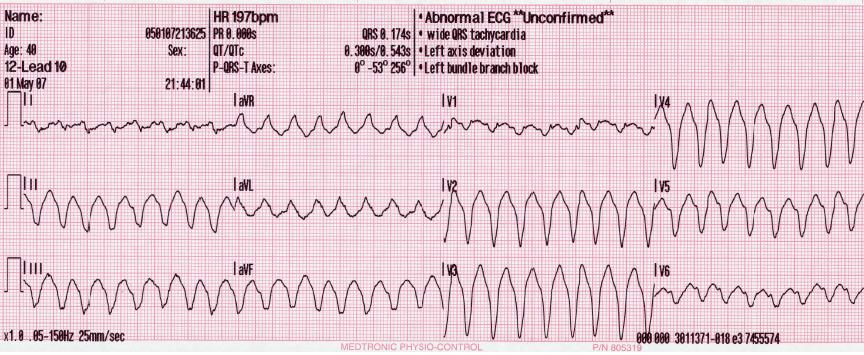

In [1]:
from IPython.display import Image
dirpath = r'C:\Users\joeba\OneDrive\Documents\ML\arrythmia'
Image(dirpath + '/12_lead_generated_ventricular_tachycardia.jpg', width=1000, height=800)

In [2]:
#List of arrhythmias - copied from the data description
#Class code:    Class:                                       Number of instances:
#01             Normal                                       245
#02             Ischemic changes (Coronary Artery Disease)   44
#03             Old Anterior Myocardial Infarction           15
#04             Old Inferior Myocardial Infarction           15
#05             Sinus tachycardy                             13
#06             Sinus bradycardy                             25
#07             Ventricular Premature Contraction (PVC)      3
#08             Supraventricular Premature Contraction       2
#09             Left bundle branch block                     9
#10             Right bundle branch block                    50
#11             1. degree AtrioVentricular block             0
#12             2. degree AV block                           0
#13             3. degree AV block                           0
#14             Left ventricule hypertrophy                  4
#15             Atrial Fibrillation or Flutter               5
#16             Others                                       22

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense

from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras import regularizers

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Using TensorFlow backend.


In [4]:
import pandas as pd
import numpy as np

# get data
wifi = 'offline' # online or offline

if wifi == 'online':
    # after doing datacamp intermediate importing data in python
    url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data'
    df = pd.read_csv(url, header=None)

else:
    df = pd.read_excel(dirpath+'/arrhythmia.data.xlsx')
    
df.head()

,Age,Sex,Height,Weight,QRS_duration,P-R_interval,Q-T_interval,T_interval,P_interval,QRS_vector_angle,...,V6_Q_wave_amplitude,V6_R_wave_amplitude,V6_S_wave_amplitude,V6_R'_wave_amplitude,V6_S'_wave_amplitude,V6_P_wave_amplitude,V6_T_wave_amplitude,V6_QRSA_area,V6_QRSTA_area,Arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In [6]:
df.isna().sum()

Age                    0
Sex                    0
Height                 0
Weight                 0
QRS_duration           0
                      ..
V6_P_wave_amplitude    0
V6_T_wave_amplitude    0
V6_QRSA_area           0
V6_QRSTA_area          0
Arrhythmia             0
Length: 280, dtype: int64

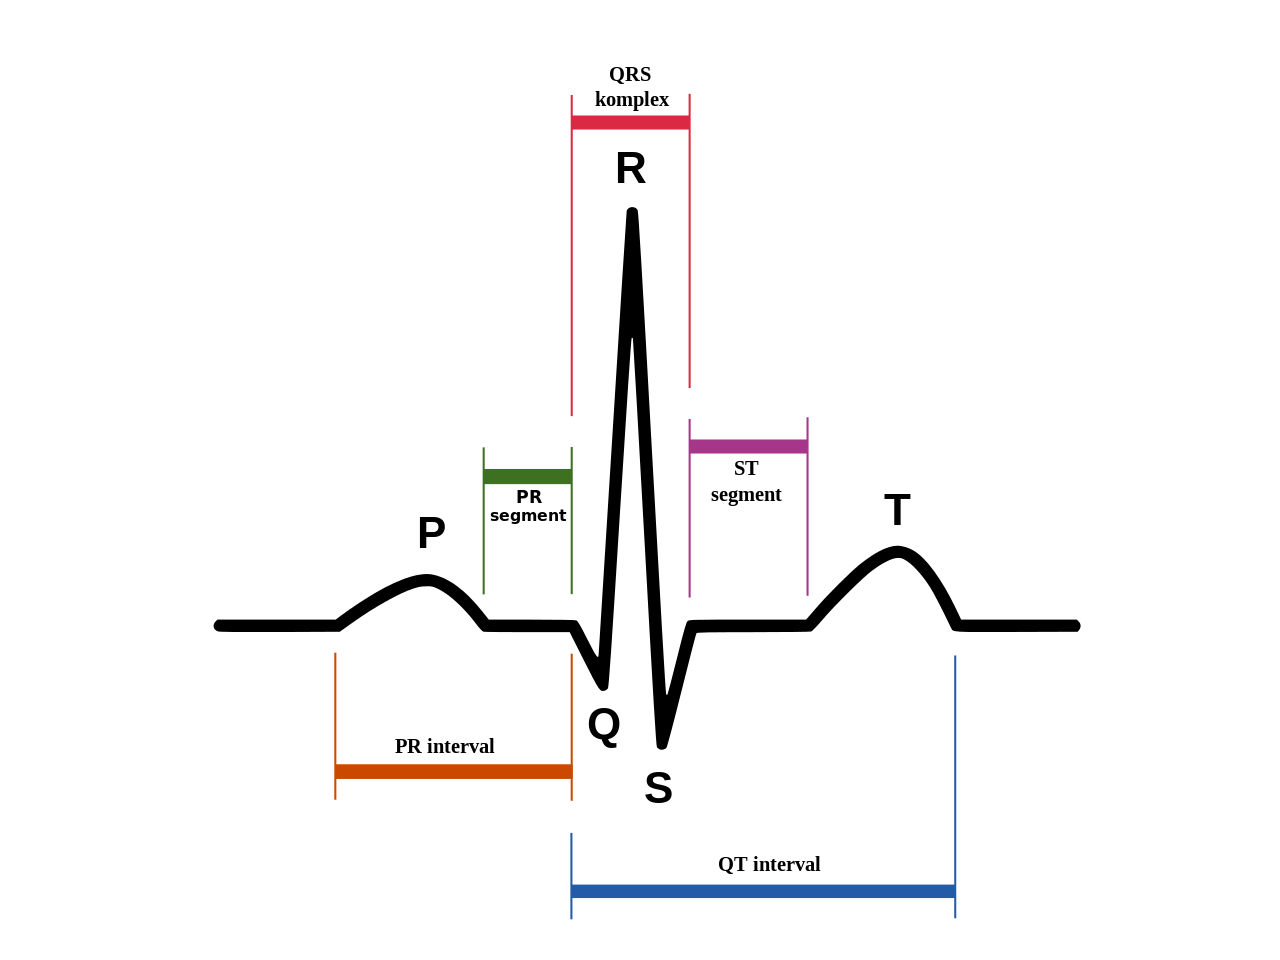

In [7]:
Image(filename = dirpath + '/ECG-PQRST.png', width=864, height=355)
# image from: https://www.wikilectures.eu/w/Electrocardiogram

In [10]:
# create a dataframe for the waveform
wf = pd.DataFrame(columns=['Milliseconds', 'Amplitude'])

arr = df.copy()

hr = arr.loc[0, 'Heart_rate']
hb_dur_min = 1.0 / hr
hb_dur_sec = hb_dur_min * 60
hb_dur_millisec = hb_dur_sec * 1000

p_start = arr.loc[0, 'P_interval']
p_amplitude = arr.loc[0, 'DI_P_wave_amplitude']

pr_interval = arr.loc[0, 'P-R_interval']

qrs_interval = arr.loc[0, 'QRS_duration']

qt_interval = arr.loc[0, 'Q-T_interval']

q_interval = arr.loc[0, 'DI_Q_wave_width']
q_amplitude = arr.loc[0, 'DI_Q_wave_amplitude']

r_interval = arr.loc[0, 'DI_R_wave_width']
r_amplitude = arr.loc[0, 'DI_R_wave_amplitude']

s_interval = arr.loc[0, 'DI_S_wave_width']
s_amplitude = arr.loc[0, 'DI_S_wave_amplitude']

t_interval = arr.loc[0, 'T_interval']
t_amplitude = arr.loc[0, 'DI_T_wave_amplitude']

print(p_start, p_amplitude)

wf = wf.append(pd.DataFrame({'Milliseconds':0, 'Amplitude':0}, index=[len(wf)]))
wf = wf.append(pd.DataFrame({'Milliseconds':p_start/2, 'Amplitude':[p_amplitude]}, index=[len(wf)]))
wf = wf.append(pd.DataFrame({'Milliseconds':p_start, 'Amplitude':0}, index=[len(wf)]))

wf = wf.append(pd.DataFrame({'Milliseconds':pr_interval, 'Amplitude':0}, index=[len(wf)]))

q_interval += pr_interval
wf = wf.append(pd.DataFrame({'Milliseconds':q_interval, 'Amplitude':q_amplitude}, index=[len(wf)]))

r_interval += q_interval
wf = wf.append(pd.DataFrame({'Milliseconds':r_interval, 'Amplitude':r_amplitude}, index=[len(wf)]))

s_interval += r_interval
wf = wf.append(pd.DataFrame({'Milliseconds':s_interval, 'Amplitude':s_amplitude}, index=[len(wf)]))

s_end = pr_interval+qrs_interval
if s_end < s_interval:
    s_end = s_interval+10
wf = wf.append(pd.DataFrame({'Milliseconds':s_end, 'Amplitude':0}, index=[len(wf)]))

# estimate st_segment as half the time remaining
t_interval = s_end+t_interval
st_segment = s_end + ((t_interval - s_end) / 2)
wf = wf.append(pd.DataFrame({'Milliseconds':st_segment, 'Amplitude':0}, index=[len(wf)]))


#wf = wf.append(pd.DataFrame({'Seconds':p_interval, 'Amplitude':[p_amplitude]}, index=[len(wf)]))
t_interval = s_end+t_interval
wf = wf.append(pd.DataFrame({'Milliseconds':t_interval, 'Amplitude':t_amplitude}, index=[len(wf)]))



121 0.6


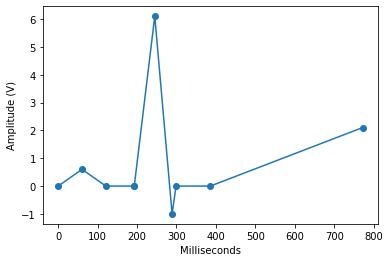

In [11]:
plt.plot(wf['Milliseconds'], wf['Amplitude'], '-o')
plt.xlabel("Milliseconds")
plt.ylabel("Amplitude (V)")
plt.show()

In [12]:
names = list(df.columns)
names

['Age',
 'Sex',
 'Height',
 'Weight',
 'QRS_duration',
 'P-R_interval',
 'Q-T_interval',
 'T_interval',
 'P_interval',
 'QRS_vector_angle',
 'T_vector_angle',
 'P_vector_angle',
 'QPRST_vector_angle',
 'J_vector_angle',
 'Heart_rate',
 'DI_Q_wave_width',
 'DI_R_wave_width',
 'DI_S_wave_width',
 "DI_R'_wave_width",
 "DI_S'_wave_width",
 'DI_intrinsic_deflections',
 'DI_ragged_R_wave',
 'DI_diphasic_derivation_R_wave',
 'DI_ragged_P_wave',
 'DI_diphasic_derivation_P_wave',
 'DI_ragged_T_wave',
 'DI_diphasic_derivation_T_wave',
 'DII_Q_wave_width',
 'DII_R_wave_width',
 'DII_S_wave_width',
 "DII_R'_wave_width",
 "DII_S'_wave_width",
 'DII_intrinsic_deflections',
 'DII_ragged_R_wave',
 'DII_DIIphasic_derivation_R_wave',
 'DII_ragged_P_wave',
 'DII_DIIphasic_derivation_P_wave',
 'DII_ragged_T_wave',
 'DII_DIIphasic_derivation_T_wave',
 'DIII_Q_wave_width',
 'DIII_R_wave_width',
 'DIII_S_wave_width',
 "DIII_R'_wave_width",
 "DIII_S'_wave_width",
 'DIII_intrinsic_deflections',
 'DIII_ragged_R

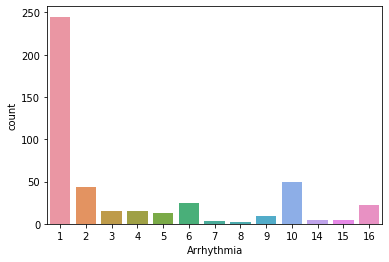

In [13]:
sns.countplot(x='Arrhythmia', data=df)

In [18]:
# find and eliminate near zero sum columns in the data
def colCount(dataset):
    
    col_count = []
    for i in range(len(dataset.columns)):
        
        cs = 0
        
        for j in range(len(dataset)):
            print(i + ' ' + j)
            cs = cs+dataset.iloc[j,i]
            
        col_count.append(cs)
        
    return col_count

cols = colCount(df)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [19]:
# drop columns with no or very little information
drop_threshold = 100
drop_cols = []
for i in range(len(cols)):
    if abs(cols[i]) <= drop_threshold:
        drop_cols.append(df.columns[i])
        
df = df.drop(labels=drop_cols,axis=1)
df

NameError: name 'cols' is not defined

In [21]:
# find and eliminate correlated columns in the data
def correlated(dataset, threshold=0.8):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return list(col_corr)

cor_cols = correlated(df,0.8)

df = df.drop(labels=cor_cols,axis=1)
df

,Age,Sex,Height,Weight,QRS_duration,P-R_interval,Q-T_interval,T_interval,P_interval,QRS_vector_angle,...,V4_T_wave_amplitude,V4_QRSA_area,V4_QRSTA_area,V5_JJ_wave_amplitude,V5_R_wave_amplitude,V5_S_wave_amplitude,V5_S'_wave_amplitude,V5_QRSA_area,V6_S'_wave_amplitude,Arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,5.1,17.7,70.7,-0.4,13.5,-4.0,0,25.5,0,8
1,56,1,165,64,81,174,401,149,39,25,...,2.6,11.8,34.6,-0.4,11.0,-2.4,0,21.6,0,6
2,54,0,172,95,138,163,386,185,102,96,...,2.2,-3.0,20.7,1.3,11.1,-3.4,0,11.5,0,10
3,55,0,175,94,100,202,380,179,143,28,...,3.3,28.8,63.1,0.1,15.2,-3.7,0,36.8,0,1
4,75,0,190,80,88,181,360,177,103,-16,...,4.9,16.2,63.2,-0.2,9.1,-0.9,0,21.7,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53,1,160,70,80,199,382,154,117,-37,...,1.4,-20.1,-9.5,0.1,4.1,-8.3,0,-8.4,0,1
448,37,0,190,85,100,137,361,201,73,86,...,5.9,69.2,129.3,-0.7,21.2,-2.8,0,50.7,0,10
449,36,0,166,68,108,176,365,194,116,-85,...,-8.2,-71.2,-161.4,0.2,22.0,-30.8,0,-39.6,0,2
450,32,1,155,55,93,106,386,218,63,54,...,3.8,17.5,56.2,0.1,15.3,-3.5,0,29.7,0,1


In [ ]:
arrhythmia.shape

<Figure size 648x144 with 0 Axes>

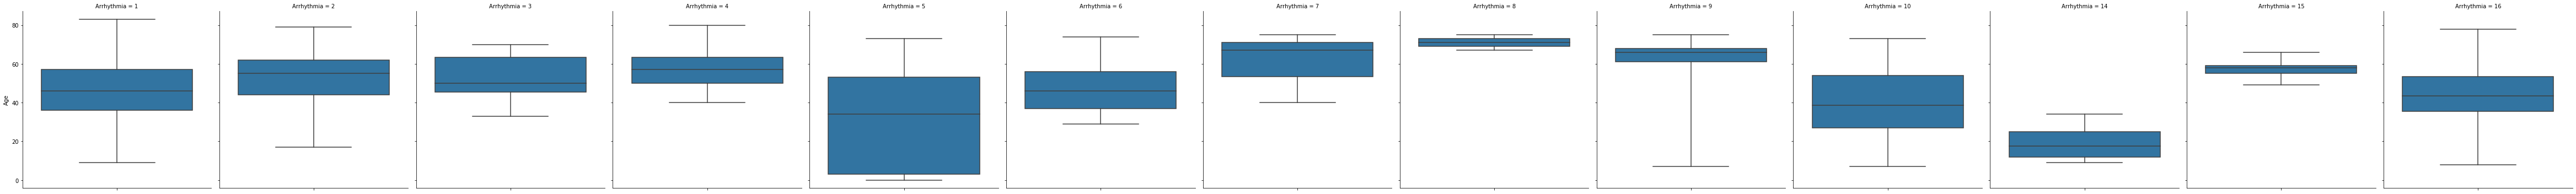

In [22]:
fig = plt.figure(1, figsize=(9, 2))
sns.catplot(y='Age', data=df, kind='box', whis=[0,100], col='Arrhythmia')
plt.show()

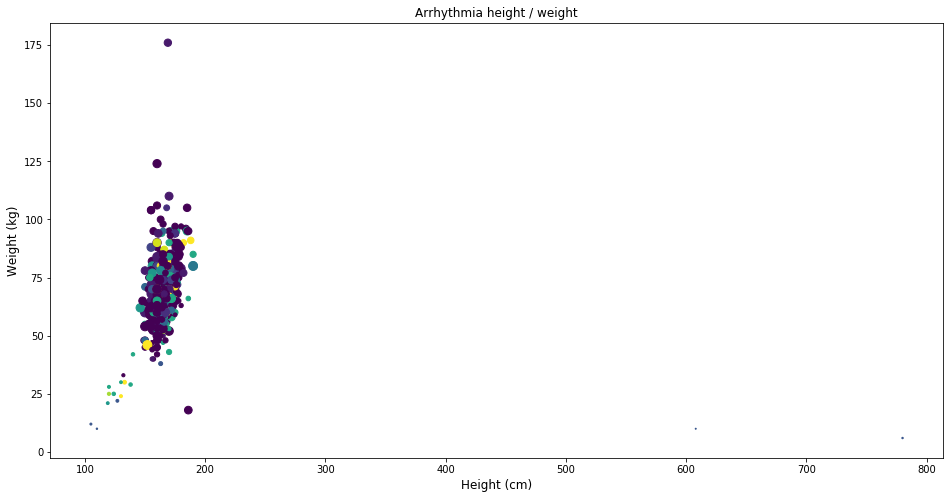

In [23]:
# looking for anomalies in height and weight
def plotArrhythmia():
    plt.figure(figsize=(16,8))
    plt.title('Arrhythmia height / weight')
    plt.scatter(x=df['Height'], y=df['Weight'], c=df['Arrhythmia'], s=(1+df['Age']))
    plt.xlabel('Height (cm)', fontsize=12)
    plt.ylabel('Weight (kg)', fontsize=12)
    #plt.legend(arrhythmia['Arrhythmia'])
    plt.show()

plotArrhythmia()

In [25]:
# show the rows with heights > 600
df.loc[df['Height'] > 600]

,Age,Sex,Height,Weight,QRS_duration,P-R_interval,Q-T_interval,T_interval,P_interval,QRS_vector_angle,...,V4_T_wave_amplitude,V4_QRSA_area,V4_QRSTA_area,V5_JJ_wave_amplitude,V5_R_wave_amplitude,V5_S_wave_amplitude,V5_S'_wave_amplitude,V5_QRSA_area,V6_S'_wave_amplitude,Arrhythmia
141,1,1,780,6,85,165,237,150,106,88,...,1.7,21.9,32.4,0.1,17.2,-7.6,0,13.5,0,5
316,0,0,608,10,83,126,232,128,60,125,...,4.8,-14.1,11.8,2.8,8.3,-9.3,0,-11.8,0,5


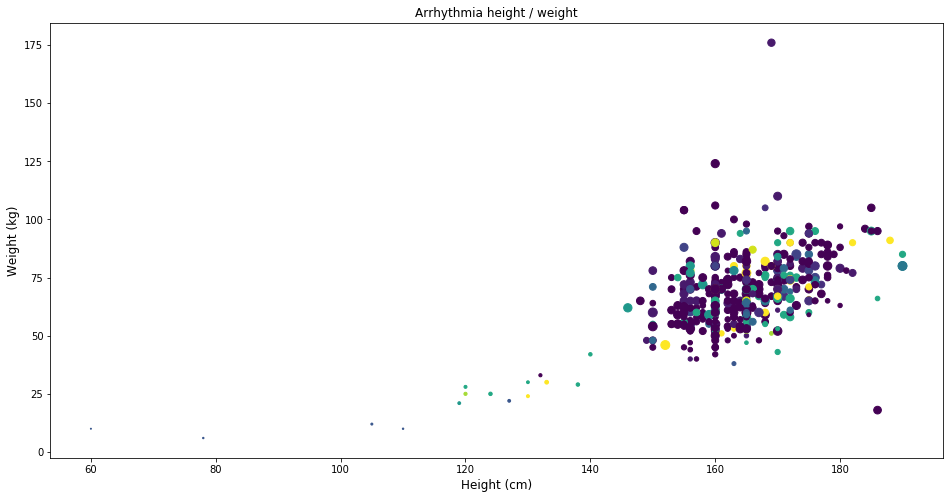

In [26]:
# by their age, both are clearly babies / toddlers
df.at[141, 'Height'] = 78.0
df.at[316, 'Height'] = 60.8
df.iloc[141]['Height'], df.iloc[316]['Height']
# re-run the scatter plot
plotArrhythmia()

In [27]:
# show the rows with weights < 20
df.loc[df['Weight'] < 20]

,Age,Sex,Height,Weight,QRS_duration,P-R_interval,Q-T_interval,T_interval,P_interval,QRS_vector_angle,...,V4_T_wave_amplitude,V4_QRSA_area,V4_QRSTA_area,V5_JJ_wave_amplitude,V5_R_wave_amplitude,V5_S_wave_amplitude,V5_S'_wave_amplitude,V5_QRSA_area,V6_S'_wave_amplitude,Arrhythmia
60,1,0,110,10,80,121,287,156,67,126,...,2.6,2.4,20.6,0.6,8.0,-6.9,0,-1.7,0,5
126,58,0,186,18,87,166,372,150,96,-1,...,2.9,0.2,23.9,0.0,7.6,-5.4,0,2.6,0,1
141,1,1,78,6,85,165,237,150,106,88,...,1.7,21.9,32.4,0.1,17.2,-7.6,0,13.5,0,5
316,0,0,60,10,83,126,232,128,60,125,...,4.8,-14.1,11.8,2.8,8.3,-9.3,0,-11.8,0,5
320,3,0,105,12,69,155,240,133,64,93,...,0.4,0.3,1.6,-0.2,4.8,-4.3,0,3.3,0,5


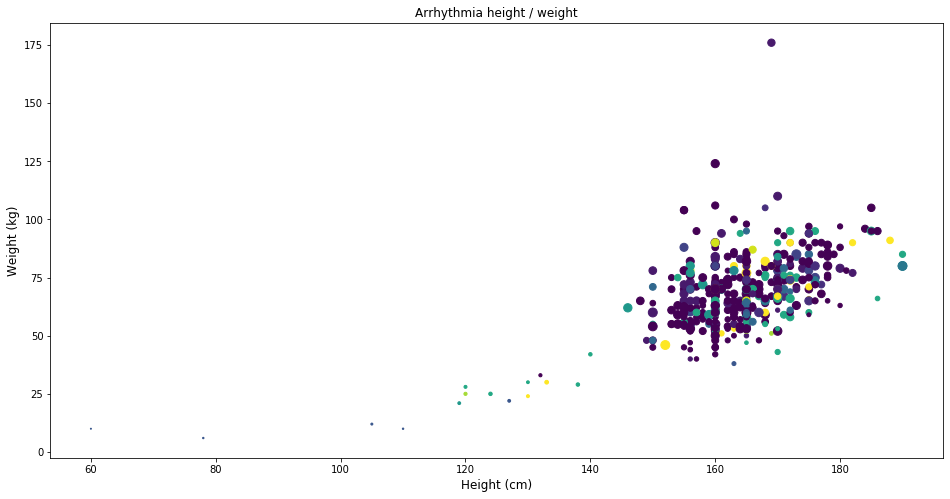

In [28]:
# 58 year old female 186 high, weighing in at only 18kg ??? - and who has a normal heart rhythm???
#arrhythmia.at[126, 'Weight'] = 78.0
df = df.drop(index=126,axis=0)
# re-run the scatter plot
plotArrhythmia()

In [30]:
# show the very heavy individual - shows a 53 yr old female - with coronary artery disease - typo?
df.loc[df['Weight'] > 170]

,Age,Sex,Height,Weight,QRS_duration,P-R_interval,Q-T_interval,T_interval,P_interval,QRS_vector_angle,...,V4_T_wave_amplitude,V4_QRSA_area,V4_QRSTA_area,V5_JJ_wave_amplitude,V5_R_wave_amplitude,V5_S_wave_amplitude,V5_S'_wave_amplitude,V5_QRSA_area,V6_S'_wave_amplitude,Arrhythmia


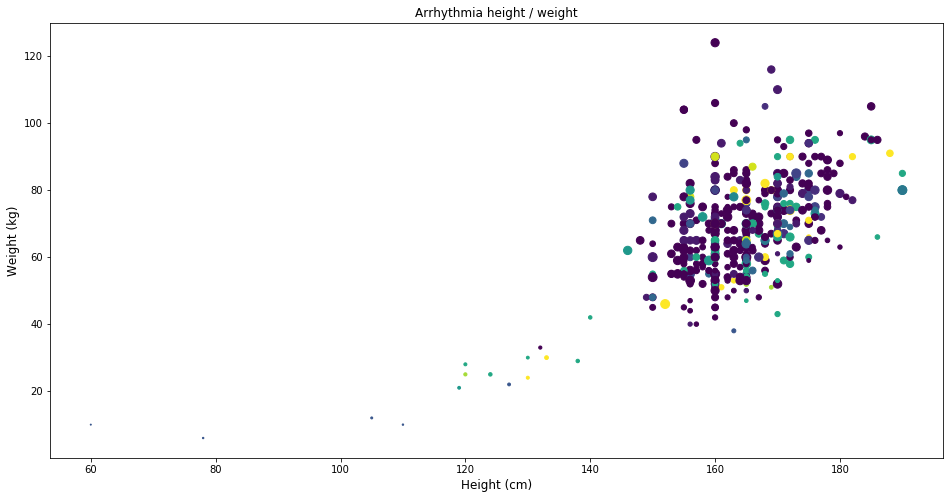

In [31]:
# let's assume that that is a transcription error from handwritten notes
df.at[213, 'Weight'] = 116.0
# re-run the scatter plot
plotArrhythmia()

In [32]:
df.to_csv('C:/Users/joeba/OneDrive/Documents/ML/arrythmia/arrhythmia.cleaned.csv', index=False)

In [33]:
df.columns.to_list()

['Age',
 'Sex',
 'Height',
 'Weight',
 'QRS_duration',
 'P-R_interval',
 'Q-T_interval',
 'T_interval',
 'P_interval',
 'QRS_vector_angle',
 'T_vector_angle',
 'P_vector_angle',
 'QPRST_vector_angle',
 'J_vector_angle',
 'Heart_rate',
 'DI_Q_wave_width',
 'DI_R_wave_width',
 'DI_S_wave_width',
 "DI_R'_wave_width",
 "DI_S'_wave_width",
 'DI_intrinsic_deflections',
 'DI_ragged_R_wave',
 'DI_diphasic_derivation_R_wave',
 'DI_ragged_P_wave',
 'DI_diphasic_derivation_P_wave',
 'DI_ragged_T_wave',
 'DI_diphasic_derivation_T_wave',
 'DII_Q_wave_width',
 'DII_R_wave_width',
 'DII_S_wave_width',
 "DII_R'_wave_width",
 "DII_S'_wave_width",
 'DII_intrinsic_deflections',
 'DII_ragged_R_wave',
 'DII_DIIphasic_derivation_R_wave',
 'DII_ragged_P_wave',
 'DII_DIIphasic_derivation_P_wave',
 'DII_ragged_T_wave',
 'DII_DIIphasic_derivation_T_wave',
 'DIII_Q_wave_width',
 'DIII_R_wave_width',
 'DIII_S_wave_width',
 "DIII_R'_wave_width",
 "DIII_S'_wave_width",
 'DIII_intrinsic_deflections',
 'DIII_ragged_R

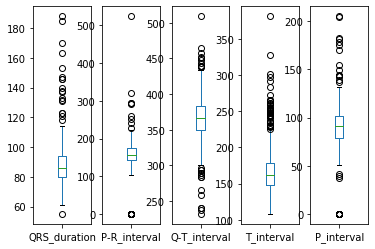

In [34]:
# Make a list of the column names to be plotted: cols
cols = ['QRS_duration','P-R_interval','Q-T_interval','T_interval','P_interval']

# Generate the box plots
df[cols].plot(kind='box', subplots=True)

# Display the plot
plt.show()

C:\Users\joeba\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 1152x576 with 0 Axes>

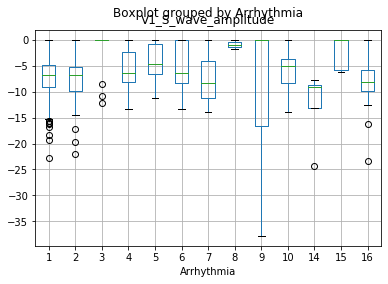

In [35]:
fig = plt.figure(1, figsize=(16, 8))
df.boxplot(column='V1_S_wave_amplitude', by='Arrhythmia')
plt.show()

C:\Users\joeba\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


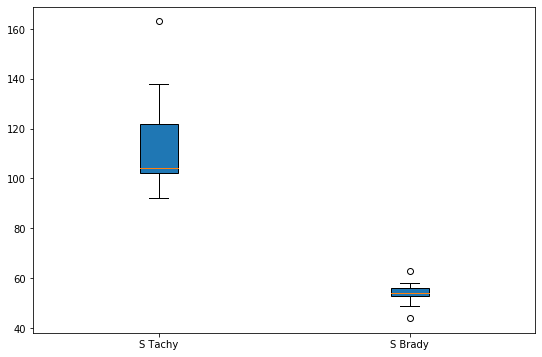

In [37]:
# sinus tachycardia & bradycardia
# https://en.wikipedia.org/wiki/Sinus_tachycardia
sinus_tachy = df.loc[df['Arrhythmia'] == 5]
sinus_brady = df.loc[df['Arrhythmia'] == 6]
                            
s_tachy = np.array(sinus_tachy['Heart_rate'])
s_brady = np.array(sinus_brady['Heart_rate'])

# expect tachy to have HR > 100, brady < 60
all_data = [s_tachy, s_brady]
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(all_data,patch_artist=True,labels=['S Tachy','S Brady'])

plt.show()

In [38]:
# split into data and classes
X = df.iloc[:, 0:118].values
x = df.iloc[:, 0:118].columns
Y = df.iloc[:, 119].values
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [39]:
# get counts of each label class - data is considerably imbalanced
def labelCounts(labels):
    counts_dict = {}
    mL = 0
    
    for i in range(len(labels)):
        # iterate through labels and add to counts_dict
        if labels[i] not in counts_dict:
            counts_dict[labels[i]] = 1
        else:
            counts_dict[labels[i]] = counts_dict[labels[i]]+1
        
        # get the max value of label
        if labels[i] >= mL:
            mL = labels[i]
            
    #arr_counts = []
    #for j in range(mL):
    #    arr_counts.append(0)
    
    
    #for j in range(mL):
    #    if j in counts_dict:
    #        arr_counts[j] = counts_dict[j]
        
    #return arr_counts[1:mL]
    return counts_dict

arrhythmia_dict = labelCounts(Y)

#np.sum(arr_counts[1:17])

In [40]:
df['Arrhythmia'].value_counts()

1     244
10     50
2      44
6      25
16     22
4      15
3      15
5      13
9       9
15      5
14      4
7       3
8       2
Name: Arrhythmia, dtype: int64

In [41]:
# scale the data assuming that there will be outliers in the data 
from sklearn import preprocessing
#X = preprocessing.robust_scale(X)
X = preprocessing.scale(X)

ValueError: could not convert string to float: '?'

In [ ]:
# training test set split - 80% being used to train and (default) ensuring even stratification of output in test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
y_test

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20,input_shape=(118,), activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd', loss='mse')

In [ ]:
# fit model over 200 epochs
history = model.fit(X_train, y_train, epochs=200, batch_size=10, verbose=0)
history_dict = history.history

In [ ]:
# what are the results?
print('Accuracy : %.3f' % accuracy_score(y_pred, y_test))
print('Error    : %.3f' % (1 - accuracy_score(y_pred, y_test)))
print('Precision: %.3f' % precision_score(y_pred, y_test))
print('Recall   : %.3f' % recall_score(y_pred, y_test))

In [ ]:
# evaluate the performance of the neural network
y_pred = model.predict(X_test)
y_pred = np.rint(y_pred)

cm = confusion_matrix(y_test, y_pred)
cm

#            predicted
#            N   P
#           +-----
# actual  N |TN  FP
#         P |FN  TP

In [ ]:
# evaluate the performance of the SVM
y_pred = svc.predict(X_test)
y_pred

In [ ]:
yt_dict = labelCounts(y_test)
yt_dict

In [ ]:
yp_dict = labelCounts(y_pred)
yp_dict

In [ ]:
# make the multilabel confusion matrix
cm = np.zeros((len(y_test), len(y_pred)), dtype=int)

for i in range(len(y_test)):
    cm[y_test[i],y_pred[i]] = cm[y_test[i],y_pred[i]]+1

# slice off the zero index
cm = cm[1:17,1:17]
cm

In [ ]:
# what was the accuracy of our prediction on the test set?
#accuracy = np.sum((np.identity(cm.shape[1])*cm)) / np.sum(cm)
svc.score(X_test, y_test) # could also get the value from the svm itself
#accuracy

In [ ]:
# determine performance by class
diag = []
for i in range(cm.shape[0]):
    diag.append(cm[i,i])
    
test = []
pred = []

for i in range(1,17):
    test.append(yt_dict.get(i,0))
    pred.append(yp_dict.get(i,0))

print(test)
print(pred)
print(diag)

In [ ]:
# display the performance by class
def plotPerformanceByClass(title):
    labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(16,8))
    rects1 = ax.bar(x - width, test, width, label='Test')
    rects2 = ax.bar(x, pred, width, label='Predicted')
    rects3 = ax.bar(x + width, diag, width, label='Correct')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.legend()

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(title)

    #fig.tight_layout()

    plt.show()
    
plotPerformanceByClass('Scores by class')

In [ ]:
# reduce to binary classification - arrhythmia or not arrhythmmia
def binaryAccuracyPrecisionRecall(conmat):
    cm_binary = np.zeros((2, 2), dtype=int)
        
    # TP and TN relatively easy
    cm_binary[0,0] = conmat[0,0]
    
    diag = []
    for i in range(conmat.shape[0]):
        diag.append(conmat[i,i])
    
    cm_binary[1,1] = np.sum(diag)-conmat[0,0]

    # FP is the sum of col 0, less the TP
    for i in range(len(conmat)):
        cm_binary[0,1] = cm_binary[0,1] + conmat[i,0]
    cm_binary[0,1] = cm_binary[0,1] - cm_binary[0,0]

    # FN - sum of cm, less the cm_binary values
    cm_binary[1,0] = np.sum(conmat) - (cm_binary[0,0] + cm_binary[1,1] + cm_binary[0,1])
    
    # show & summary scores
    print(cm_binary)

    print("binary accuracy   : ", (cm_binary[0,0] + cm_binary[1,1]) / np.sum(cm_binary))
    print("binary precision  : ", cm_binary[0,0] / (cm_binary[0,0] + cm_binary[0,1]))
    print("binary recall     : ", cm_binary[0,0] / (cm_binary[0,0] + cm_binary[1,0]))

binaryAccuracyPrecisionRecall(cm)

In [ ]:
# eliminate from the original (cleaned) data any classes with less than 10 instances
def setA2(arrhythmia):
    arrhythmia2 = arrhythmia.loc[arrhythmia['Arrhythmia'] != 7]
    arrhythmia2 = arrhythmia2.loc[arrhythmia2['Arrhythmia'] != 8]
    arrhythmia2 = arrhythmia2.loc[arrhythmia2['Arrhythmia'] != 9]
    arrhythmia2 = arrhythmia2.loc[arrhythmia2['Arrhythmia'] != 14]
    arrhythmia2 = arrhythmia2.loc[arrhythmia2['Arrhythmia'] != 15]
    
    return arrhythmia2

def printA2Counts(arrhythmia2):
    print(arrhythmia2['Arrhythmia'].value_counts().to_list())
    print(np.min(arrhythmia2['Arrhythmia'].value_counts().to_list()))

arrhythmia2 = setA2(arrhythmia)
printA2Counts(arrhythmia2)

In [ ]:
# dictionaries to keep scores
accuracy_oversample = {
    20 : [], 30 : [], 40 : [], 50 : [], 60 : [], 70 : [], 80 : [], 90 : [], 100 : [], 110 : [], 120 : [], 130 : [], 140 : [], 150 : []
}

accuracy_original = {
    20 : [], 30 : [], 40 : [], 50 : [], 60 : [], 70 : [], 80 : [], 90 : [], 100 : [], 110 : [], 120 : [], 130 : [], 140 : [], 150 : []
}

In [ ]:
# simple randomised over sampling
# https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

import random

def oversample(min_level, arrhythmia2):

    while np.min(arrhythmia2['Arrhythmia'].value_counts().to_list()) < min_level:
        #print(arrhythmia2.shape)
        i = random.randint(0,len(arrhythmia2)-1)
        #print(i)
        #print(arrhythmia2.iloc[i]['Arrhythmia'])
        if((len(arrhythmia2.loc[arrhythmia2['Arrhythmia'] == arrhythmia2.iloc[i]['Arrhythmia']])) < min_level):
            #print('found a record to add with replacement')
            arrhythmia2 = arrhythmia2.append(arrhythmia2.iloc[i], ignore_index=True)
        #else:
            #print('got enough of these already')
    
    return arrhythmia2



In [ ]:
# for each level
for lvl in range(20, 151, 10):
    
    accuracy_oversample[lvl].clear()
    accuracy_original[lvl].clear()
    
    print("oversampling data to level = " + str(lvl))
    
    for t in range(0,10):
        
        # reset trial data from THE original data
        arrhythmia2 = setA2(arrhythmia)
        
        # oversample 
        arrhythmia2 = oversample(lvl, arrhythmia2)
        #printA2Counts(arrhythmia2)

        # split arrhythmia2 into data and classes
        X2 = arrhythmia2.iloc[:, 0:118].values
        x2 = arrhythmia2.iloc[:, 0:118].columns
        Y2 = arrhythmia2.iloc[:, 119].values
        #Y2
    
        # scale the data
        X2 = preprocessing.scale(X2)
    
        # training test set split - 80% being used to train and (default) ensuring even stratification of output in test set
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=1)
        svc.fit(X2_train, y2_train)
    
        # evaluate the performance of the SVM trained on oversampled data
        y2_pred = svc.predict(X2_test)
        accuracy_oversample[lvl].append(svc.score(X2_test, y2_test))
    
        # evaluate the performance of the SVM trained on oversampled data BUT on the ORIGINAL test data
        y_pred = svc.predict(X_test)
        accuracy_original[lvl].append(svc.score(X_test, y_test))

In [ ]:
# get and plot the accuracies at different levels of oversampling
accuracies_oversampled = []
accuracies_original = []
for i in range(20,151,10):
    accuracies_oversampled.append(np.average(accuracy_oversample[i]))
    accuracies_original.append(np.average(accuracy_original[i]))

levels = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]

oversampled_trend = np.linspace(accuracies_oversampled[0], accuracies_oversampled[-1], len(levels))
original_trend = np.linspace(accuracies_original[0], accuracies_original[-1], len(levels))

plt.figure(figsize=(16,8))
#plt.title('Oversampling performance - average of 10 trials')
plt.xticks(levels)
plt.plot(levels, accuracies_oversampled)
plt.plot(levels,oversampled_trend)
plt.plot(levels,accuracies_original)
plt.plot(levels,original_trend)
plt.ylabel('Accuracy')
plt.xlabel('Oversampling level')

plt.show()

In [ ]:
oversampled_trend = np.linspace(accuracies_oversampled[0], accuracies_oversampled[-1], 13)
oversampled_trend

In [ ]:
# make the multilabel confusion matrix
yt2_dict = labelCounts(y2_test)
yp2_dict = labelCounts(y2_pred)

cm2 = np.zeros((17, 17), dtype=int)

for i in range(len(y2_test)):
    #print(int(y2_test[i]))
    cm2[int(y2_test[i]),int(y2_pred[i])] = cm2[int(y2_test[i]),int(y2_pred[i])]+1

# slice off the zero index
cm2 = cm2[1:17,1:17]
cm2

In [ ]:
# determine performance by class
diag2 = []
for i in range(cm2.shape[0]):
    diag2.append(cm2[i,i])
    
test2 = []
pred2 = []

for i in range(1,17):
    test2.append(yt2_dict.get(i,0))
    pred2.append(yp2_dict.get(i,0))

print(test2)
print(pred2)
print(diag2)

In [ ]:
# display the performance by class
labels2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

x2 = np.arange(len(labels2))  # the label locations
width = 0.25  # the width of the bars

fig2, ax2 = plt.subplots(figsize=(16,8))
rects1 = ax2.bar(x2 - width, test2, width, label='Test')
rects2 = ax2.bar(x2, pred2, width, label='Predicted')
rects3 = ax2.bar(x2 + width, diag2, width, label='Correct')

ax2.set_xticks(x2)
ax2.set_xticklabels(labels2)

ax2.legend()

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Scores')
ax2.set_title('Scores by class (oversampled data)')

#fig.tight_layout()

plt.show()

In [ ]:
print(cm2)
binaryAccuracyPrecisionRecall(cm2)